# Delta Hedging Simulation

## What is Delta Hedging?
Delta hedging is a risk management strategy used by option sellers to protect against adverse price movements in the underlying asset. When you sell (or "write") an option, you take on the obligation to either buy or sell the underlying asset at the strike price if the option is exercised. This exposure creates directional risk that can be neutralized through delta hedging.

## Delta Hedging Process for Option Sellers

When you've sold an option, you need to take the opposite position in the underlying asset to offset the directional risk:

1. **For a short call position**: You have negative delta exposure, so you need to buy shares of the underlying asset (positive delta)
2. **For a short put position**: You have positive delta exposure, so you need to sell/short shares of the underlying asset (negative delta)

## Hedging Setup
In the following simulation, we assume the role of the bank and sell the European option (Put/Call). There are 3 main instruments, namely the Bank Account $B_t$, the Option $V_t$ and the Asset $S_t$.

The portfolio $C_t$ would be constructed using the delta amounts of the asset together with the bank account: <br>
$C_t = \delta S_t + B_t , 0 \leq t \leq T$

Since it is a replicating **self-financing** portfolio, the option value must equal to the constructed portfolio value at all times until the option expiry: <br>
$C_t = V_t, 0 \leq t \leq T$


All the Black-Scholes assumptions will apply, namely:
1) No liquidity restrictions.
2) No Transaction Costs.
3) Access to the Bank Account which accrues continuously. <br>
$dB_t = r B_t dt$
4) Lognormal Dynamics for the underlying Asset. <br>
$dS_t = \mu S_t dt + \sigma S_t dW_t$   

## Mathematics Involved

### Call Option Formula

$$C_t = S_t N(d_1) - Ke^{-rT} N(d_2)$$

### Put Option Formula

$$P_t = Ke^{-rT} N(-d_2) - S_t N(-d_1)$$

### Where

$$d_1 = \frac{\ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

#### Parameters:
- $S_t$ = Current stock price
- $K$ = Strike price
- $r$ = Risk-free interest rate (continuous compounding)
- $T$ = Time to maturity (in years)
- $\sigma$ = Volatility of the underlying asset
- $N(x)$ = Cumulative distribution function of the standard normal distribution

### Put Call Parity (Option)
$C_t - P_t = S_t - Ke^{-rT}$

### Put Call Parity (Delta)
$\Delta_P = \Delta_C - 1$ where $0 \leq \Delta_C \leq 1$ and $-1 \leq \Delta_P \leq 0$

In [15]:
import numpy as np
import pandas as pd
import random
from scipy import stats
import matplotlib.pyplot as plt

#Call or put European Option
def hedge_sim(optype):
    
    if optype.upper() not in ["C", "P"]:
        raise ValueError("Input must be 'C' or 'P'")
    
    #If we sell the option we are long the delta
    random.seed(0)
    dt = T / nbTimeSteps
    t = np.linspace(0, T, nbTimeSteps + 1)
    s = np.zeros(nbTimeSteps + 1)
    s[0] = s0
    z = np.random.rand(nbTimeSteps)
    
    for i in range(1, nbTimeSteps + 1):
        s[i] = s[i - 1] + s[i - 1] * (mu * dt + vol * np.sqrt(dt) * z[i - 1])
        
    #Calculate the delta of the option
    d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))
    d2 = d1 - vol*np.sqrt(T-t)
    if optype.upper() == 'C':
        delta = stats.norm.cdf(d1)
    else:
        delta = stats.norm.cdf(d1) - 1 #Put-call parity
        
    #BSM EU call price at different time and stock prices
    c = s*stats.norm.cdf(d1) - K*np.exp(-r*(T-t)) * stats.norm.cdf(d2)
    if optype.upper() == 'C':
        v = c 
    else:
        v = c - s + K*np.exp(-r*(T-t)) #Put-Call Parity
    
    data = pd.DataFrame()
    data['Time'] = t
    data['Stock Price'] = s
    data['d1'] = d1
    data['d2'] = d2
    data['Delta'] = delta
    data['Option Price'] = v
    data['Rehedge Amt'] = data['Delta'].diff() * (data['Stock Price'])
    data.loc[0,'Rehedge Amt'] = 0
    
    Account = np.zeros((nbTimeSteps + 1))
    Account[0] = v[0] - delta[0]*s[0]  
    for i in range(nbTimeSteps):
        Account[i+1] = Account[i]*np.exp(r*dt) - data['Rehedge Amt'][i+1]
    
    data['Account'] = Account
    print("*"*50)
    if optype == 'C':
        print(f'The final net account balance is ${round(Account[-1] + np.where(s[-1]-K>0,K,0),2)}')
    if optype == 'P':
        print(f'The final net account balance is ${round(Account[-1] + np.where(K-s[-1]>0,-K,0),2)}')
    print("*"*50)
    
    return data 

## Simulation for an In-The-Money Call Option
- Since we sold the call option, as the moneyness of the option increases, we are required to hold more and more of the asset since we have to long the delta.
- Hence, we will need to borrow more money to dynamically rehedge resulting in our bank balance to decrease over time.
- At maturity, our bank balance will drop to the strike price K and we will be holding to 1 unit of the asset. Since the option expires in-the-money, we are expected to sell the asset at K, thus making the net balance 0.

/tmp/ipykernel_397/4001787621.py:25: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))
/tmp/ipykernel_397/4001787621.py:25: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))


**************************************************
The final net account balance is $0.66
**************************************************


Text(0.5, 1.0, 'Evolution of Account Balance')

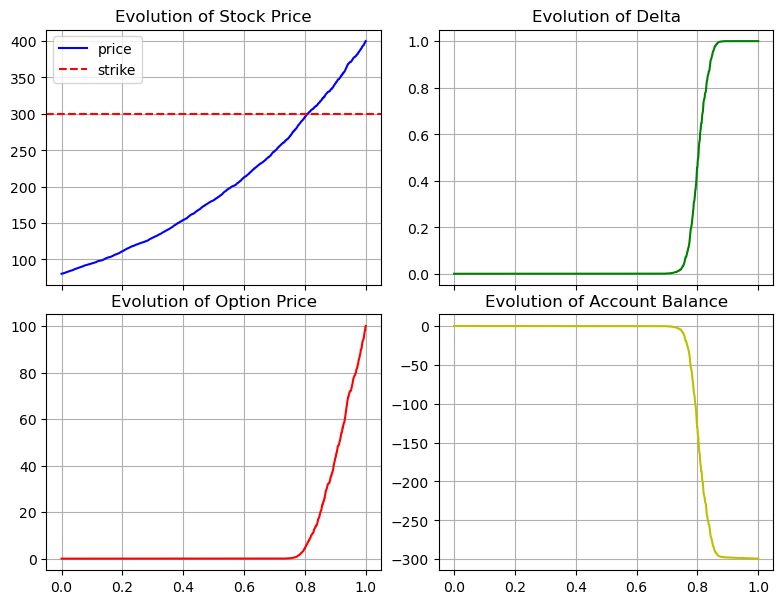

In [18]:
mu = 0.03;
vol = 0.1;
r = 0.05;
s0 = 80;
K = 100;
T = 1; #Number of years to expiry
nbTimeSteps = 1000

data = hedge_sim('C')
t = np.linspace(0, T, nbTimeSteps + 1)


fig, axs = plt.subplots(2, 2, figsize=(8, 6),sharex=(True))
fig.tight_layout()
for i in range(2):
    for j in range(2):
        axs[i,j].grid(True)


axs[0,0].plot(data['Time'],data['Stock Price'],color = 'b',label = 'price')
axs[0,0].axhline(y=K, color='r', linestyle='--',label = 'strike')
axs[0,0].set_title("Evolution of Stock Price")
axs[0,0].legend()

axs[0,1].plot(data['Time'],data['Delta'],color = 'g')
axs[0,1].set_title("Evolution of Delta")

axs[1,0].plot(data['Time'],data['Option Price'],color = 'r')
axs[1,0].set_title("Evolution of Option Price")

axs[1,1].plot(data['Time'],data['Account'],color = 'y')
axs[1,1].set_title("Evolution of Account Balance")



## Simulation for an Out-Of-The-Money Call Option

- Since we sold the call option, as the moneyness of the option decreases, we are required to hold less and less of the asset.
- Hence, we will need to dynamically rehedge by selling our asset, resulting in our bank balance to increase over time.
- At maturity, our bank balance will be at 0 and we will be holding to 0 unit of the asset as we slowly sell our asset. Since the option expires out-of-the-money, we would not need to sell the asset at K, thus making the net balance 0.

/tmp/ipykernel_124/8042150.py:25: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))


**************************************************
The final net account balance is $0.05
**************************************************


Text(0.5, 1.0, 'Evolution of Account Balance')

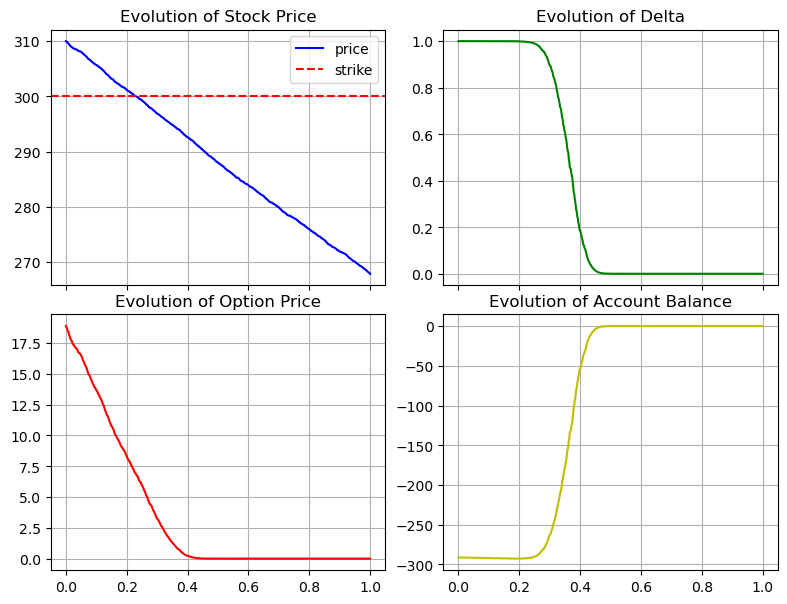

In [20]:
mu = -0.3;
vol = 0.01;
r = 0.03;
s0 = 310;
K = 300;
T = 1; #Number of years to expiry
nbTimeSteps = 1000

data = hedge_sim('C')
t = np.linspace(0, T, nbTimeSteps + 1)


fig, axs = plt.subplots(2, 2, figsize=(8, 6),sharex=(True))
fig.tight_layout()
for i in range(2):
    for j in range(2):
        axs[i,j].grid(True)


axs[0,0].plot(data['Time'],data['Stock Price'],color = 'b',label = 'price')
axs[0,0].axhline(y=K, color='r', linestyle='--',label = 'strike')
axs[0,0].set_title("Evolution of Stock Price")
axs[0,0].legend()

axs[0,1].plot(data['Time'],data['Delta'],color = 'g')
axs[0,1].set_title("Evolution of Delta")

axs[1,0].plot(data['Time'],data['Option Price'],color = 'r')
axs[1,0].set_title("Evolution of Option Price")

axs[1,1].plot(data['Time'],data['Account'],color = 'y')
axs[1,1].set_title("Evolution of Account Balance")

## Simulation for an Out-Of-The-Money Put Option
- Since we sold the put option, as the moneyness of the option decreases, we are required to sell less (buy back) of the asset since we have to long the delta.
- Hence, we will need to use our bank account to dynamically rehedge resulting in our bank balance to decrease over time.
- At maturity, our bank balance will drop to the strike price 0 and we will be holding to 0 unit of the asset. Since the option expires out-of-the-money, we are expected to sell the asset at K, thus making the net balance 0.

/tmp/ipykernel_397/4001787621.py:25: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))
/tmp/ipykernel_397/4001787621.py:25: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))


**************************************************
The final net account balance is $0.64
**************************************************


Text(0.5, 1.0, 'Evolution of Account Balance')

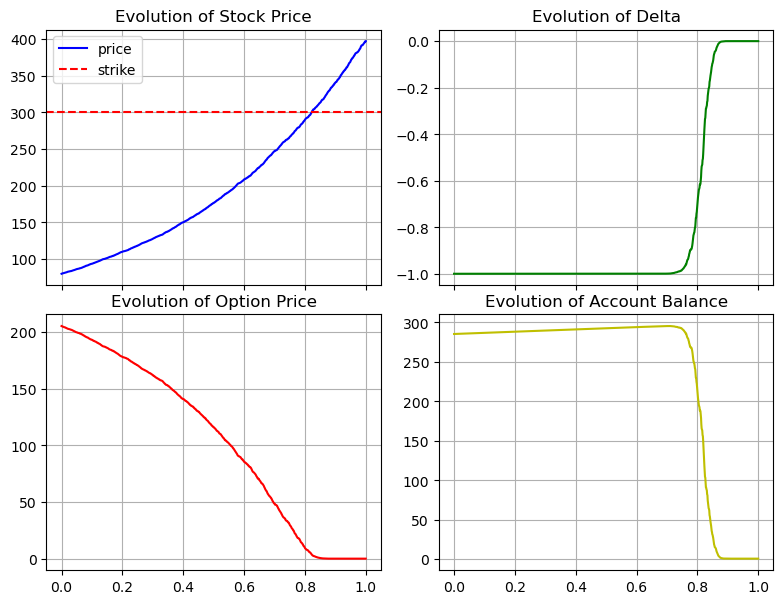

In [30]:
mu = 0.03;
vol = 0.1;
r = 0.05;
s0 = 80;
K = 300;
T = 1; #Number of years to expiry
nbTimeSteps = 1000

data = hedge_sim('P')
t = np.linspace(0, T, nbTimeSteps + 1)


fig, axs = plt.subplots(2, 2, figsize=(8, 6),sharex=(True))
fig.tight_layout()
for i in range(2):
    for j in range(2):
        axs[i,j].grid(True)


axs[0,0].plot(data['Time'],data['Stock Price'],color = 'b',label = 'price')
axs[0,0].axhline(y=K, color='r', linestyle='--',label = 'strike')
axs[0,0].set_title("Evolution of Stock Price")
axs[0,0].legend()

axs[0,1].plot(data['Time'],data['Delta'],color = 'g')
axs[0,1].set_title("Evolution of Delta")

axs[1,0].plot(data['Time'],data['Option Price'],color = 'r')
axs[1,0].set_title("Evolution of Option Price")

axs[1,1].plot(data['Time'],data['Account'],color = 'y')
axs[1,1].set_title("Evolution of Account Balance")

## Simulation for an In-The-Money Put Option
- Since we sold the put option, as the moneyness of the option increases, we are required to sell more of the asset since we have to long the delta.
- Hence, we will dynamically rehedge and sell more, resulting in our bank balance to increase over time.
- At maturity, our bank balance will increase to the strike price K and we will owe 1 unit of the asset. Since the option expires in-the-money, we are expected to buy the asset at K, thus making the net balance 0.

/tmp/ipykernel_124/8042150.py:25: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(s/K) + (r + 0.5 * vol**2) * (T-t)) /( vol*np.sqrt((T-t)))


**************************************************
The final net account balance is $0.05
**************************************************


Text(0.5, 1.0, 'Evolution of Account Balance')

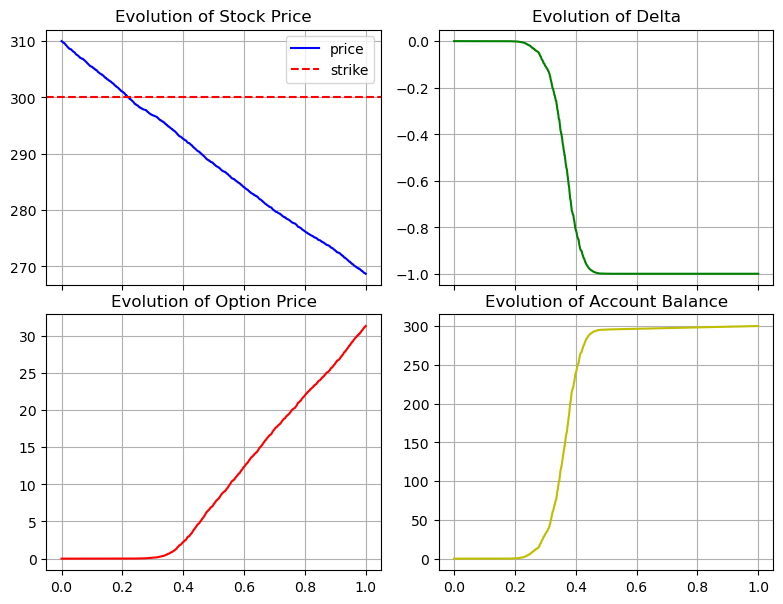

In [19]:
mu = -0.3;
vol = 0.01;
r = 0.03;
s0 = 310;
K = 300;
T = 1; #Number of years to expiry
nbTimeSteps = 1000

data = hedge_sim('P')
t = np.linspace(0, T, nbTimeSteps + 1)


fig, axs = plt.subplots(2, 2, figsize=(8, 6),sharex=(True))
fig.tight_layout()
for i in range(2):
    for j in range(2):
        axs[i,j].grid(True)


axs[0,0].plot(data['Time'],data['Stock Price'],color = 'b',label = 'price')
axs[0,0].axhline(y=K, color='r', linestyle='--',label = 'strike')
axs[0,0].set_title("Evolution of Stock Price")
axs[0,0].legend()

axs[0,1].plot(data['Time'],data['Delta'],color = 'g')
axs[0,1].set_title("Evolution of Delta")

axs[1,0].plot(data['Time'],data['Option Price'],color = 'r')
axs[1,0].set_title("Evolution of Option Price")

axs[1,1].plot(data['Time'],data['Account'],color = 'y')
axs[1,1].set_title("Evolution of Account Balance")

# Conclusion

- We ran through 2 x 2 examples, namely (In-The-Money, Out-Of-The-Money) x (Call, Put). In the examples above, all the stock price process passed the stike, meaning it either was out-of-the-money and went in-the-money or vice versa. However, for options that stayed either out-of-the-money or in-the-money throughout the option's life, the change in the delta is small and hence, the rehedging is small. At maturity, the delta will be at 0 for out-of-the-money options and either 1 and -1 for call and put options respectively.
- In practice, since bank know the amount to hedge, they would replicate portfolio $C_t$ for from the time the option is sold to the maturity of the option. These options would be sold at a premium to cover hedging inefficiencies, slippages and transaction cost.
- Losely speaking, $\Delta V = \frac{\partial V}{\partial t} \Delta t + \frac{\partial V}{\partial S} \Delta S + \frac{\partial^2 V}{\partial S^2} \Delta S^2 + HOT$. Hence, to improve hedging, one can take a gamma hedge as well. Advantages of gamma hedging includes protection against large price movements in the underlying asset. This is especially the case of volatile underlying assets like commodities, futures and cryptocurrencies.